In [1]:
import nltk
import sys
import pandas as pd
import re
import time
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.model_selection import train_test_split

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

data = pd.read_csv("SMSSpamCollection.tsv", sep='\t')
data.columns = ['label', 'body_text']

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

def clean_text(text):
    
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

#label 10% of data

X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data['label'], test_size=0.9)
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])


tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

data_model = tfidf_vect_fit.transform(data['body_text'])
data_x = pd.concat([data[['body_len', 'punct%']].reset_index(drop=False), 
           pd.DataFrame(data_model.toarray())], axis=1).to_numpy()
data_y = data["label"].to_numpy()


X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=False), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=False), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)
# y_train.reset_index(inplace=True)
# y_test.reset_index(inplace=True)
columns = X_test_vect.shape[1]
X_train_vectNP = X_train_vect.to_numpy()
y_trainNP = y_train.to_numpy()
X_test_vectNP = X_test_vect.to_numpy()
y_testNP = y_test.to_numpy()
X_test_vect.head()

,index,body_len,punct%,0,1,2,3,4,5,6,...,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077
0,3186,109,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,205,31,9.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1971,27,3.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3192,37,10.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4156,53,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
def ActiveLearn(learner, X_test, y_test):
    performance_history = []
    times = []
    percentage = []
    while len(learner.y_training) < 3336:
        percentage.append(len(learner.y_training) / (len(X_train_vectNP) + len(X_test_vectNP)))
        start = time.time()
        query_index, query_instance = learner.query(X_test, n_instances = 10)
        # Teach our ActiveLearner model the record it has requested.
        X, y = X_test[query_index].reshape(10, columns), y_test[query_index].reshape(10,)
        learner.teach(X=X, y=y)

        # Remove the queried instance from the unlabeled pool.
        X_test, y_test = np.delete(X_test, query_index, axis=0), np.delete(y_test, query_index)

        #Calculate and report our model's accuracy.
        model_accuracy = learner.score(data_x, data_y)
        performance_history.append(model_accuracy)
        end = time.time()
        times.append(end - start)
        if len(learner.y_training) % 10 == 0:
            print(model_accuracy)
    return performance_history, times, percentage

In [3]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#MDA will be completed in RStudio
import seaborn as sns
import matplotlib.style as style
import matplotlib.pyplot as plt
%matplotlib inline

knn = KNeighborsClassifier(n_neighbors=5)
svc = SVC(probability = True)

## Random Forest with Uncertainty Sampling

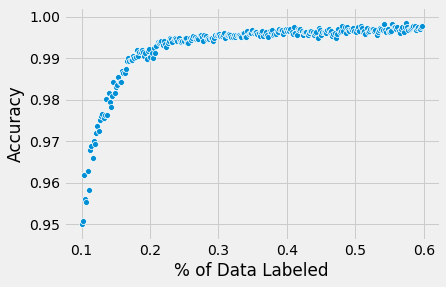

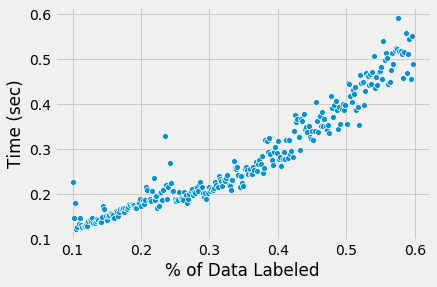

In [4]:
learner_Unc_RF = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_train_vectNP, y_training=y_trainNP)

Accuracy_Unc_RF, Time_Unc_RF, perc_Unc_RF = ActiveLearn(learner_Unc_RF, X_test_vectNP, y_testNP)
style.use('fivethirtyeight')
plt.xlabel("% of Data Labeled")
plt.ylabel("Accuracy")
sns.scatterplot(perc_Unc_RF, Accuracy_Unc_RF)
plt.show()

plt.xlabel("% of Data Labeled")
plt.ylabel("Time (sec)")
sns.scatterplot(perc_Unc_RF, Time_Unc_RF)
plt.show()

## Random Forest with Entropy Sampling

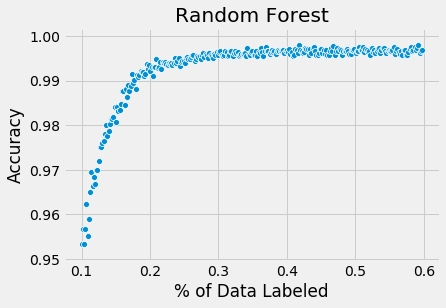

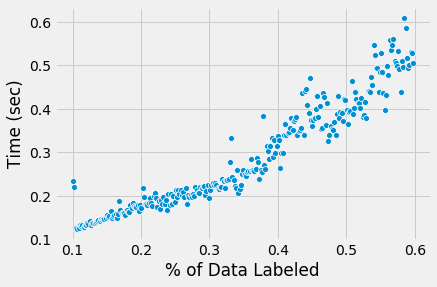

In [5]:
learner_Ent_RF = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=entropy_sampling,
    X_training=X_train_vectNP, y_training=y_trainNP)

Accuracy_Ent_RF, Time_Ent_RF, perc_Ent_RF = ActiveLearn(learner_Ent_RF, X_test_vectNP, y_testNP)
style.use('fivethirtyeight')
plt.title("Random Forest")
plt.xlabel("% of Data Labeled")
plt.ylabel("Accuracy")
sns.scatterplot(perc_Ent_RF, Accuracy_Ent_RF)
plt.show()

plt.xlabel("% of Data Labeled")
plt.ylabel("Time (sec)")
sns.scatterplot(perc_Ent_RF, Time_Ent_RF)
plt.show()

### Perform T-Test?

## K-NN with Uncertainty Sampling

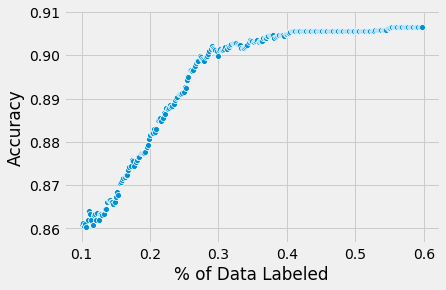

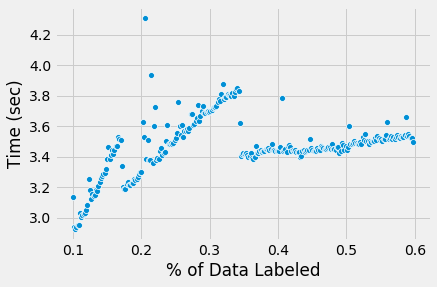

In [6]:
learner_Unc_KNN = ActiveLearner(
    estimator=knn,
    query_strategy=uncertainty_sampling,
    X_training=X_train_vectNP, y_training=y_trainNP)

Accuracy_Unc_KNN, Time_Unc_KNN, perc_Unc_KNN = ActiveLearn(learner_Unc_KNN, X_test_vectNP, y_testNP)
style.use('fivethirtyeight')
plt.xlabel("% of Data Labeled")
plt.ylabel("Accuracy")
sns.scatterplot(perc_Unc_KNN, Accuracy_Unc_KNN)
plt.show()

plt.xlabel("% of Data Labeled")
plt.ylabel("Time (sec)")
sns.scatterplot(perc_Unc_KNN, Time_Unc_KNN)
plt.show()

## KNN with Entropy Sampling

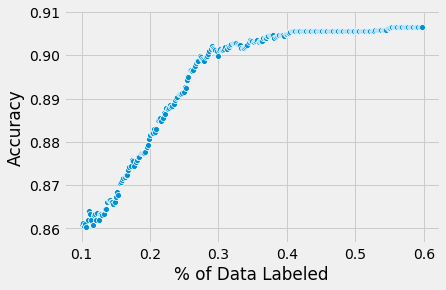

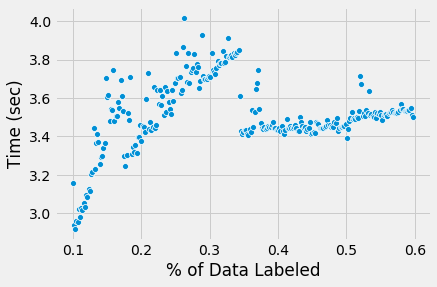

In [7]:
learner_Ent_KNN = ActiveLearner(
    estimator=knn,
    query_strategy=entropy_sampling,
    X_training=X_train_vectNP, y_training=y_trainNP)

Accuracy_Ent_KNN, Time_Ent_KNN, perc_Ent_KNN = ActiveLearn(learner_Ent_KNN, X_test_vectNP, y_testNP)
style.use('fivethirtyeight')
plt.xlabel("% of Data Labeled")
plt.ylabel("Accuracy")
sns.scatterplot(perc_Ent_KNN, Accuracy_Ent_KNN)
plt.show()

plt.xlabel("% of Data Labeled")
plt.ylabel("Time (sec)")
sns.scatterplot(perc_Ent_KNN, Time_Ent_KNN)
plt.show()

## SVM with Uncertainty Sampling

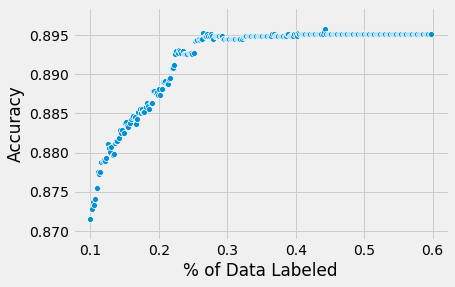

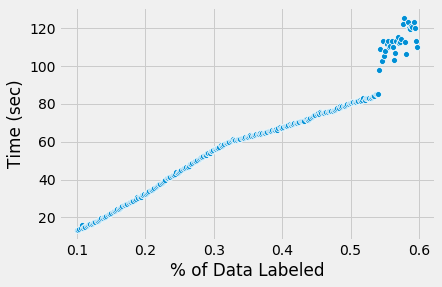

In [8]:
learner_Ent_SVM = ActiveLearner(
    estimator=svc,
    query_strategy=entropy_sampling,
    X_training=X_train_vectNP, y_training=y_trainNP)

Accuracy_Unc_SVM, Time_Unc_SVM, perc_Unc_SVM = ActiveLearn(learner_Unc_SVM, X_test_vectNP, y_testNP)
style.use('fivethirtyeight')
plt.xlabel("% of Data Labeled")
plt.ylabel("Accuracy")
sns.scatterplot(perc_Unc_SVM, Accuracy_Unc_SVM)
plt.show()

plt.xlabel("% of Data Labeled")
plt.ylabel("Time (sec)")
sns.scatterplot(perc_Unc_SVM, Time_Unc_SVM)
plt.show()

## SVM with Entropy Sampling

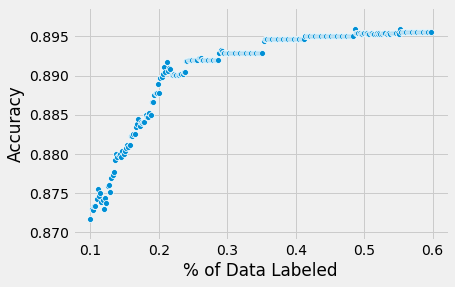

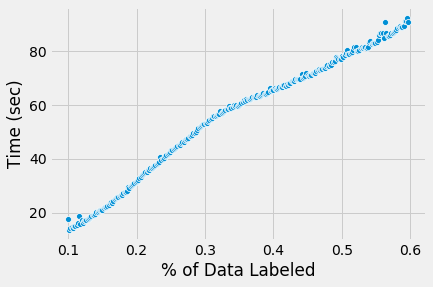

In [9]:
learner_Ent_SVM = ActiveLearner(
    estimator=svc,
    query_strategy=entropy_sampling,
    X_training=X_train_vectNP, y_training=y_trainNP)

Accuracy_Ent_SVM, Time_Ent_SVM, perc_Ent_SVM = ActiveLearn(learner_Ent_SVM, X_test_vectNP, y_testNP)
style.use('fivethirtyeight')
plt.xlabel("% of Data Labeled")
plt.ylabel("Accuracy")
sns.scatterplot(perc_Ent_SVM, Accuracy_Ent_SVM)
plt.show()

plt.xlabel("% of Data Labeled")
plt.ylabel("Time (sec)")
sns.scatterplot(perc_Ent_SVM, Time_Ent_SVM)
plt.show()

In [12]:
pd.DataFrame({"Percentage": perc_Unc_RF, "Accuracy": Accuracy_Unc_RF, "Time": Time_Unc_RF}).to_csv("Unc_RF.csv")
pd.DataFrame({"Percentage": perc_Ent_RF, "Accuracy": Accuracy_Ent_RF, "Time": Time_Ent_RF}).to_csv("Ent_RF.csv")
pd.DataFrame({"Percentage": perc_Unc_KNN, "Accuracy": Accuracy_Unc_KNN, "Time": Time_Unc_KNN}).to_csv("Unc_KNN.csv")
pd.DataFrame({"Percentage": perc_Ent_KNN, "Accuracy": Accuracy_Ent_KNN, "Time": Time_Ent_KNN}).to_csv("Ent_KNN.csv")
pd.DataFrame({"Percentage": perc_Unc_SVM, "Accuracy": Accuracy_Unc_SVM, "Time": Time_Unc_SVM}).to_csv("Unc_SVM.csv")
pd.DataFrame({"Percentage": perc_Ent_SVM, "Accuracy": Accuracy_Ent_SVM, "Time": Time_Ent_SVM}).to_csv("Ent_SVM.csv")